# LUAD survival analysis

#### Data sources:
- `rna_cancer_sample.tsv`: Human Protein Atlas (https://www.proteinatlas.org/download/rna_cancer_sample.tsv.zip)
- `clinical.tsv`: TCGA (https://portal.gdc.cancer.gov/projects/TCGA-LUAD; click Clinical download button)

Data were pre-normalized as part of the Human Protein Atlas project

#### Table of contents:
<ul>
    <li><a href="#import">Import dependencies</a></li>
    <li><a href="#functions">Functions</a></li>
    <li><a href="#read">Read gene expression data and format</a></li>
    <li><a href="#censor">Read clinical data and format/censor</a></li>
    <li><a href="#summary">Data summaries</a></li>
    <li><a href="#sms">SMS (ENSG00000102172)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#glyctk">GLYCTK (ENSG00000168237)</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#all">Perform analysis on all genes</a></li>    
    <li><a href="#rank">Rank order survival p-values</a></li>   
        <ul>
           <li>SMS</li>
           <li>GLYCTK</li>
        </ul>
    <li><a href="#plots">Plots</a></li>
        <ul>
           <li>All stages</li>
           <li>Early stages</li>
           <li>Late stages</li>
        </ul>
    <li><a href="#session">Session Info</a></li>
</ul>

<a id="import"><h3>Import dependencies</h3></a>

In [1]:
suppressWarnings({
    library(survival)
    library(survminer)
    library(stringr)
    library(data.table)

    setwd("C:/Users/jorda/Desktop/projects/manuscript/rna_cancer_data/tcga_classic/")
})

Loading required package: ggplot2

Loading required package: ggpubr



ERROR: Error in setwd("C:/Users/jorda/Desktop/projects/manuscript/rna_cancer_data/tcga_classic/"): cannot change working directory


<a id="functions"><h3>Functions</h3></a>

In [ ]:
# Clean and prepare clinical data 
censor_df <- function (df) {
    # Censor alive==0/dead==1
    # See "event" description at https://www.rdocumentation.org/packages/survival/versions/2.11-4/topics/Surv
    censor_data <- function(x) if (x == "Alive") {0} else {1}
    df$status <- mapply(censor_data, df$vital_status)
    df$status <- as.numeric(df$status)
    df$days_to_death <- as.numeric(df$days_to_death) ##################### <-------- NAs
    
    # Right censor for alive
    # https://cran.r-project.org/web/packages/finalfit/vignettes/survival.html
    df$days_to_death <- ifelse(
        is.na(df$days_to_death), 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    df$days_to_death <- ifelse(
        df$days_to_death == "'--", 
        df$days_to_last_follow_up, 
        df$days_to_death)
    
    return (df)
}

clean_df <- function(df) {
    # Get relevant data and perform some additional data clean-up
    df <- df[ , c("case_submitter_id", "ajcc_pathologic_stage", "status", "days_to_death", "days_to_last_follow_up")] 

    # remove duplicate entries
    df <- unique(df[,])

    # remove samples with no days to death after censoring
    df <- df[df$days_to_death != "'--", ]

    # Make sure output formatting is correct
    df$status <- as.numeric(as.character(df$status))
    df$days_to_death <- as.numeric(as.character(df$days_to_death))
    
    return (df)
}

parse_stages <- function(df) {
    
    # Add stage category labels
    df$stage <- df$ajcc_pathologic_stage
    df <- df[df$stage != "'--", ]
    df$stage[
        df$stage == "Stage I" | 
        df$stage == "Stage IA" | 
        df$stage == "Stage IB"] <- 1
    df$stage[
        df$stage == "Stage II" | 
        df$stage == "Stage IIA" | 
        df$stage == "Stage IIB"] <- 2
    df$stage[
        df$stage == "Stage III" | 
        df$stage == "Stage IIIA" | 
        df$stage == "Stage IIIB"] <- 3
    df$stage[
        df$stage == "Stage IV" | 
        df$stage == "Stage IVA" | 
        df$stage == "Stage IVB"] <- 4

    # Parse out early vs. late patients
    early <- df[
        df$ajcc_pathologic_stage == "Stage I" | 
        df$ajcc_pathologic_stage == "Stage IA" | 
        df$ajcc_pathologic_stage == "Stage IB", ]
    late <- df[
        df$ajcc_pathologic_stage != "Stage I" & 
        df$ajcc_pathologic_stage != "Stage IA" & 
        df$ajcc_pathologic_stage != "Stage IB", ]
    all <- df
    
    v = list(all, early, late)
    names(v) <- c("all", "early", "late")
    
    return (v)
}

In [ ]:
plot_day_dist <- function(df, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    # initialize plotting space 
    par(mfrow=c(1,2), pin=c(3,1))
    
    # plot days to death for dead patients distribution
    x1 <- df[df$status == 1, ]$days_to_death
    h1 <-hist(x1, breaks=20, col="red", xlab="Days to Death", main="Dead")
    xfit1<-seq(min(x1),max(x1),length=40)
    yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
    yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
    lines(xfit1, yfit1, col="red", lwd=2)
    
    # plot days to follow-up for alive patients distribution
    x2 <- df[df$status == 0, ]$days_to_death
    h2 <- hist(x2, breaks=20, col="blue", xlab="Days to Follow-up", main="Alive")
    xfit2<-seq(min(x2),max(x2),length=40)
    yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

plot_gene_summary <- function(df, gene, title=NULL, export=FALSE, color="blue") {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(paste(title, "gene expression summary"))
    print(summary(df[df$Gene == gene,]$FPKM))

    x2 <- df[df$Gene == gene, ]$FPKM
    h2 <- hist(x2, breaks=100, col="grey", xlab="FPKM", main=title)
    xfit2<-seq(min(x2),max(x2),length=40)
    yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
    yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
    lines(xfit2, yfit2, col="blue", lwd=2)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [2]:
analyze_all_genes <- function(expression, clinical, gene_list) {
    
    median_pvals <-list()
    optimized_pvals <- list()
    counter <- 0

    for (gene in gene_list) {
      tryCatch({
        data_gene <- expression[expression$Gene == gene,]
        # Merged mixed data tables
        merged_data_gene <- merge(
          data_gene,
          clinical,
          by.x = "Sample",
          by.y = "case_submitter_id")

        this_median <- median(merged_data_gene$FPKM)
        merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > this_median, "high", "low")
        km_trt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

        opt_cutoff <- surv_cutpoint(
            merged_data_gene, 
            time = "days_to_death", 
            event = "status", 
            variables = c("FPKM"),
            minprop=0.2)
        opt_categories <- surv_categorize(opt_cutoff)
        opt_fit <- surv_fit(Surv(days_to_death, status) ~ FPKM, data = opt_categories)

        median_pvals[gene] <- surv_pvalue(km_trt_fit)$pval
        optimized_pvals[gene] <- surv_pvalue(opt_fit)$pval
          
      }, error = function (condition) {
        counter <- counter + 1
      })
    }
    print(paste("Skipped", counter, "genes", sep=" "))
    
    v = list(median_pvals, optimized_pvals)
    names(v) <- c("median", "optimized")
    
    return (v)
}

In [3]:
plot_scatter <- function(expression, clinical, gene, title=NULL, export=FALSE) {
    if (export != FALSE) {
        pdf(export)
    }
    
    if (is.null(title)) {
        title = gene
    }
    
    print(title)
    data_gene <- expression[expression$Gene == gene,]
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    plot(merged_data_gene$FPKM, merged_data_gene$days_to_death)
    
    if (export != FALSE) {
        dev.off()
    }
}

In [4]:
get_best_cutoff <- function(expression, clinical, gene, title=NULL, stage="All", minprop=0.2) {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    # K-M Curve
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")
    
    # Optimized threshold
    opt_cutoff <- surv_cutpoint(
        data = merged_data_gene, 
        time = "days_to_death", 
        event = "status", 
        variables = c("FPKM"),
        minprop=minprop)
    opt_categories <- surv_categorize(x = opt_cutoff)
    opt_fit <- surv_fit(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)
    
    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Optimized cutoff:", opt_cutoff$cutpoint$cutpoint))
    print(paste("Best fit p-value:", val_opt))
    print(paste("high:", sum(str_count(opt_categories$FPKM, "high"))))
    print(paste("low:", sum(str_count(opt_categories$FPKM, "low"))))

    # Cox Regression
    res.cox <- coxph(Surv(days_to_death, status) ~ FPKM, data=opt_categories)
    print(summary(res.cox))
 
    best_value = list(opt_fit, opt_cutoff, opt_cutoff$cutpoint$cutpoint, opt_categories, val_opt)
    names(best_value) = list("model", "cutoff_obj", "cutoff", "categories", "p_val")
    return (best_value)
}

use_cutoff <- function(expression, clinical, gene, cutoff, title=NULL, stage="All") {
    if (is.null(title)) {
        title = gene
    }
    print(paste(stage, ":::", title))
    
    data_gene <- expression[expression$Gene == gene,]
    # Merged mixed data tables
    merged_data_gene <- merge(
      data_gene,
      clinical,
      by.x = "Sample",
      by.y = "case_submitter_id")

    merged_data_gene$gene_status <- ifelse(merged_data_gene$FPKM > cutoff, "high", "low")
    opt_fit <- surv_fit(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)

    # Get p-values
    val_opt <- surv_pvalue(opt_fit)$pval

    # Print stats
    print(paste("Used cutoff:", cutoff))
    print(paste("Used p-value:", val_opt))
    print(paste("high:", sum(str_count(merged_data_gene$gene_status, "high"))))
    print(paste("low:", sum(str_count(merged_data_gene$gene_status, "low"))))
    
    res.cox <- coxph(Surv(days_to_death, status) ~ gene_status, data=merged_data_gene)
    print(summary(res.cox))
    
    best_value = list(opt_fit, val_opt)
    names(best_value) = list("model", "p_val")
    return (best_value)
}

<a id="read"><h3>Read gene expression data and format</h3></a>

In [5]:
rpkm_data <- read.csv(
    file = 'rna_cancer_sample.tsv', 
    sep="\t")

# Extract LUAD data
rpkm_data <- rpkm_data[rpkm_data$Cancer == 'LUAD',]

# Clean up Sample IDs
rpkm_data$Sample <- sapply(strsplit(rpkm_data$Sample, "-01A"), "[", 1)
gene_list <- unique(rpkm_data$Gene)
rpkm_data$FPKM <- as.numeric(rpkm_data$FPKM)

dim(rpkm_data)

[1] 9728500       4

<a id="censor"><h3>Read clinical data and format/censor</h3></a> 

In [6]:
clinical_data <- read.csv(
    file = "clinical.tsv", 
    sep="\t")

clinical_data <- censor_df(
    clinical_data)
dim(clinical_data)

clinical_data <- clean_df(
    clinical_data)
dim(clinical_data)

clinical_data <- parse_stages(
    clinical_data)

ERROR: Error in censor_df(clinical_data): could not find function "censor_df"


<a id="summary"><h3>Data summaries</h3></a>

In [ ]:
# plot day distribtions for groups
plot_day_dist(
    clinical_data$all,
    export="patient_distribution.pdf")

In [ ]:
plot_gene_summary(
    rpkm_data, 
    "ENSG00000102172", 
    "SMS",
    export="gene_summary_sms.pdf")

In [ ]:
plot_gene_summary(
    rpkm_data, 
    "ENSG00000168237", 
    "GLYCTK",
    export="gene_summary_glyctk.pdf")

In [ ]:
# Plot both in same plotting space

In [ ]:
pdf("gene_summary_both.pdf", height=8, width=10)

# initialize plotting space 
par(mfrow=c(1,2), pin=c(3,3))

x1 <- rpkm_data[rpkm_data$Gene == "ENSG00000102172", ]$FPKM
h1 <- hist(x1, breaks=100, col="grey", xlab="FPKM", main="SMS")
xfit1<-seq(min(x1),max(x1),length=40)
yfit1<-dnorm(xfit1,mean=mean(x1),sd=sd(x1))
yfit1 <- yfit1*diff(h1$mids[1:2])*length(x1)
lines(xfit1, yfit1, col="blue", lwd=2)

x2 <- rpkm_data[rpkm_data$Gene == "ENSG00000168237", ]$FPKM
h2 <- hist(x2, breaks=100, col="grey", xlab="FPKM", main="GLYCTK")
xfit2<-seq(min(x2),max(x2),length=40)
yfit2<-dnorm(xfit2,mean=mean(x2),sd=sd(x2))
yfit2 <- yfit2*diff(h2$mids[1:2])*length(x2)
lines(xfit2, yfit2, col="blue", lwd=2)

dev.off()

### =========================================================================================

<a id="sms"><h3>SMS (ENSG00000102172)</h3></a>

#### All stages

[1] "SMS"


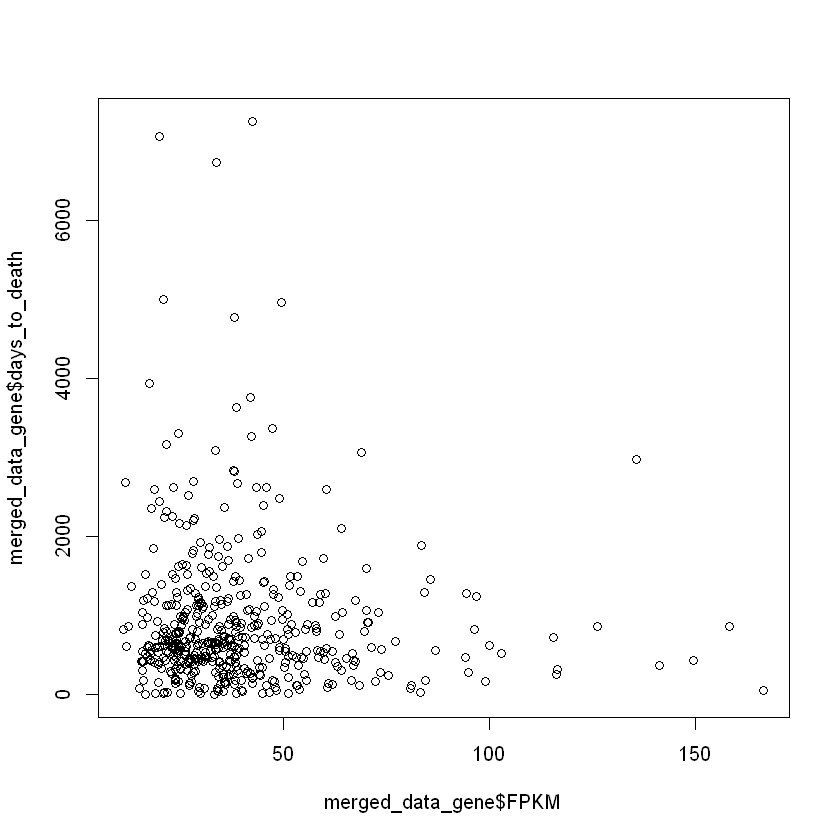

In [114]:
plot_scatter(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000102172", 
    "SMS")

In [147]:
best_values_sms_all <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$all, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="All")

[1] "All ::: SMS"
[1] "Optimized cutoff: 49.5413"
[1] "Best fit p-value: 2.92888467053861e-06"
[1] "high: 105"
[1] "low: 382"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 487, number of events= 177 

           coef exp(coef) se(coef)      z Pr(>|z|)    
FPKMlow -0.7461    0.4742   0.1632 -4.571 4.85e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4742      2.109    0.3444     0.653

Concordance= 0.567  (se = 0.019 )
Likelihood ratio test= 18.88  on 1 df,   p=1e-05
Wald test            = 20.89  on 1 df,   p=5e-06
Score (logrank) test = 21.87  on 1 df,   p=3e-06



In [185]:
pdf("stat_dist_sms_all.pdf")
plot(
    best_values_sms_all$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [186]:
model <- best_values_sms_all$model
p_val <- best_values_sms_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_all.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Early stages

[1] "SMS"


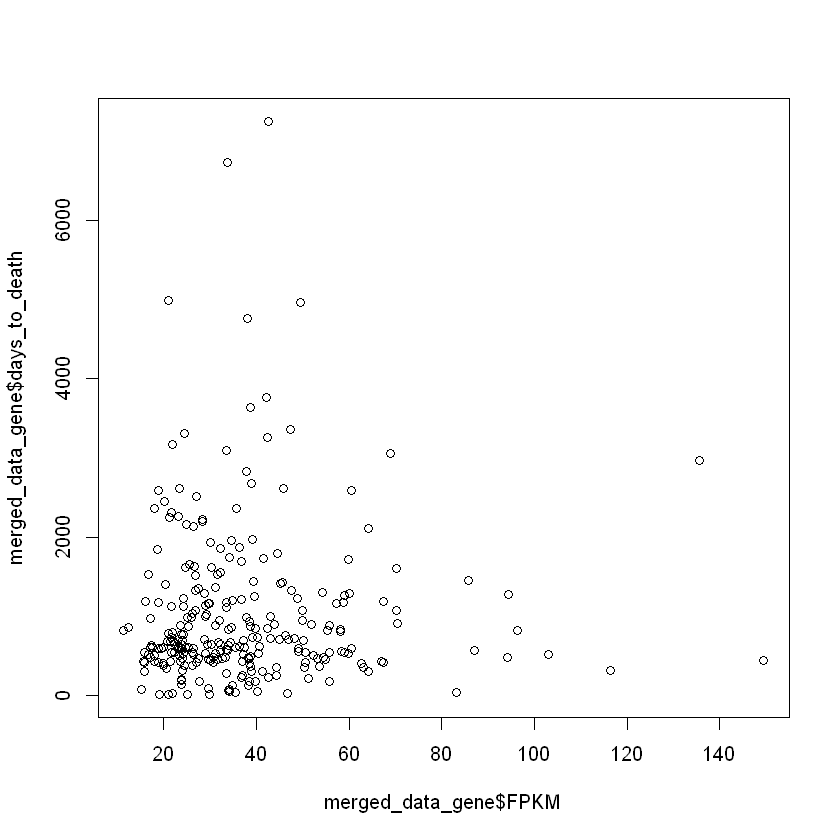

In [150]:
plot_scatter(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    "SMS")

In [151]:
use_values_early <- use_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Early")

[1] "Early ::: SMS"
[1] "Used cutoff: 49.5413"
[1] "Used p-value: 0.00021161907604961"
[1] "high: 51"
[1] "low: 213"
Call:
coxph(formula = Surv(days_to_death, status) ~ gene_status, data = merged_data_gene)

  n= 264, number of events= 63 

                  coef exp(coef) se(coef)      z Pr(>|z|)    
gene_statuslow -0.9707    0.3788   0.2722 -3.566 0.000362 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
gene_statuslow    0.3788       2.64    0.2222    0.6459

Concordance= 0.585  (se = 0.034 )
Likelihood ratio test= 11.26  on 1 df,   p=8e-04
Wald test            = 12.72  on 1 df,   p=4e-04
Score (logrank) test = 13.73  on 1 df,   p=2e-04



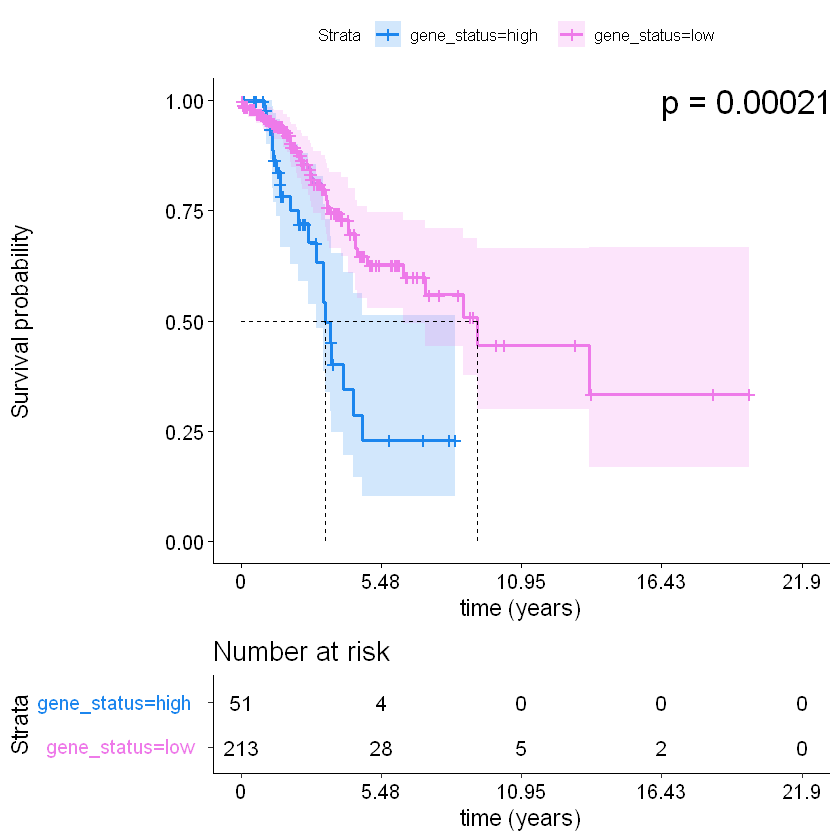

In [152]:
model <- use_values_early$model
p_val <- use_values_early$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [153]:
best_values_sms_early <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$early, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="early")

[1] "early ::: SMS"
[1] "Optimized cutoff: 48.239"
[1] "Best fit p-value: 0.000365689639380748"
[1] "high: 55"
[1] "low: 209"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 264, number of events= 63 

           coef exp(coef) se(coef)      z Pr(>|z|)    
FPKMlow -0.9069    0.4038   0.2631 -3.447 0.000567 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4038      2.477    0.2411    0.6762

Concordance= 0.58  (se = 0.034 )
Likelihood ratio test= 10.7  on 1 df,   p=0.001
Wald test            = 11.88  on 1 df,   p=6e-04
Score (logrank) test = 12.7  on 1 df,   p=4e-04



In [187]:
pdf("stat_dist_sms_early.pdf")
plot(
    best_values_sms_early$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [188]:
model <- best_values_sms_early$model
p_val <- best_values_sms_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_early.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Late stages

[1] "SMS"


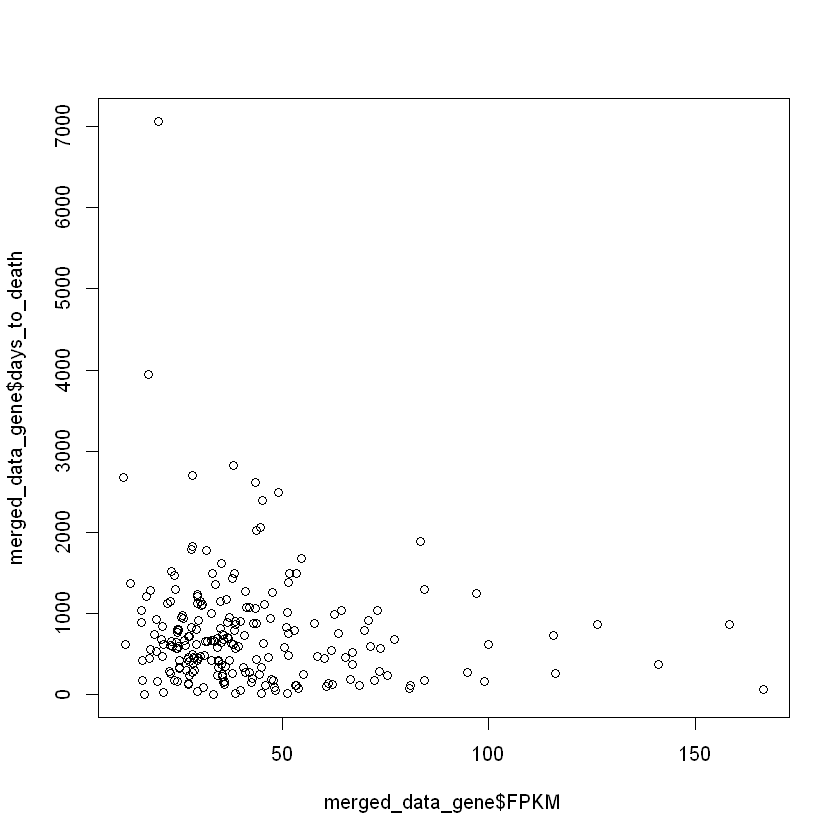

In [156]:
plot_scatter(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    "SMS")

In [157]:
use_values_late <- use_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
     best_values_sms_all$cutoff, 
    title="SMS", 
    stage="Late")

[1] "Late ::: SMS"
[1] "Used cutoff: 49.5413"
[1] "Used p-value: 0.00312343789508907"
[1] "high: 54"
[1] "low: 169"
Call:
coxph(formula = Surv(days_to_death, status) ~ gene_status, data = merged_data_gene)

  n= 223, number of events= 114 

                  coef exp(coef) se(coef)      z Pr(>|z|)   
gene_statuslow -0.5984    0.5497   0.2055 -2.911   0.0036 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

               exp(coef) exp(-coef) lower .95 upper .95
gene_statuslow    0.5497      1.819    0.3674    0.8224

Concordance= 0.558  (se = 0.024 )
Likelihood ratio test= 7.82  on 1 df,   p=0.005
Wald test            = 8.48  on 1 df,   p=0.004
Score (logrank) test = 8.73  on 1 df,   p=0.003



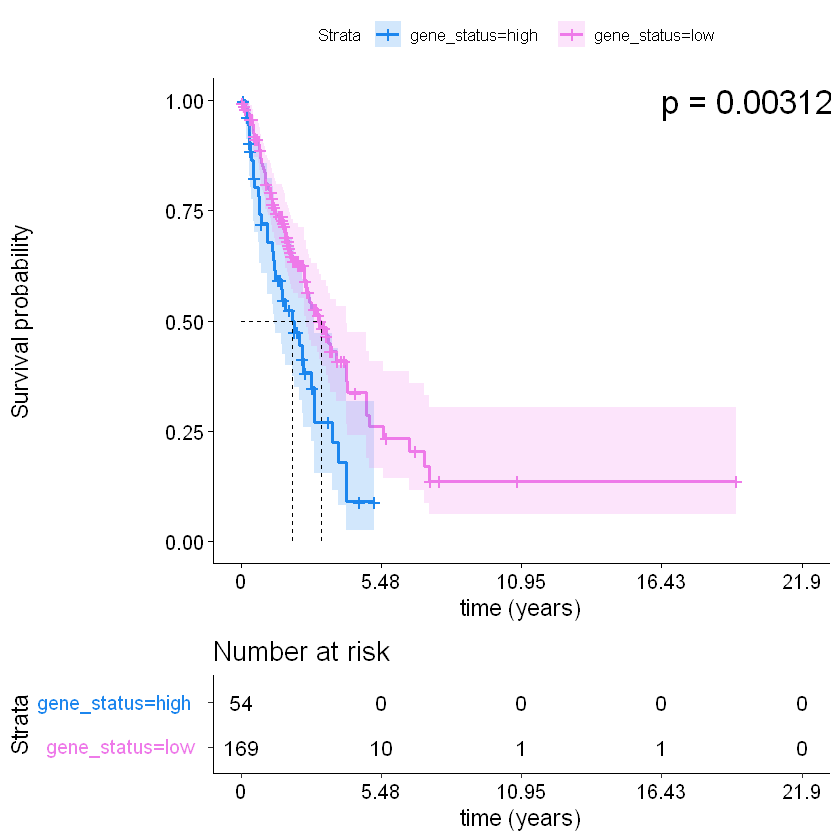

In [158]:
model <- use_values_late$model
p_val <- use_values_late$p_val
dig_round=7
p_pos=c(6000,1)

#pdf()
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
#dev.off()

In [159]:
best_values_sms_late <- get_best_cutoff(
    expression=rpkm_data, 
    clinical=clinical_data$late, 
    gene="ENSG00000102172", 
    title="SMS", 
    stage="late")

[1] "late ::: SMS"
[1] "Optimized cutoff: 24.971"
[1] "Best fit p-value: 0.00360953569815356"
[1] "high: 179"
[1] "low: 44"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 223, number of events= 114 

           coef exp(coef) se(coef)      z Pr(>|z|)   
FPKMlow -0.8382    0.4325   0.2964 -2.828  0.00469 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow    0.4325      2.312    0.2419    0.7732

Concordance= 0.549  (se = 0.021 )
Likelihood ratio test= 9.85  on 1 df,   p=0.002
Wald test            = 8  on 1 df,   p=0.005
Score (logrank) test = 8.46  on 1 df,   p=0.004



In [189]:
pdf("stat_dist_sms_late.pdf")
plot(
    best_values_sms_late$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


png 
  2

In [190]:
model <- best_values_sms_late$model
p_val <- best_values_sms_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_sms_late.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

### -----------------------------------------------------------------------------------------

<a id="glyctk"><h3>GLYCTK (ENSG00000168237)</h3></a>

#### All stages

[1] "GLYCTK"


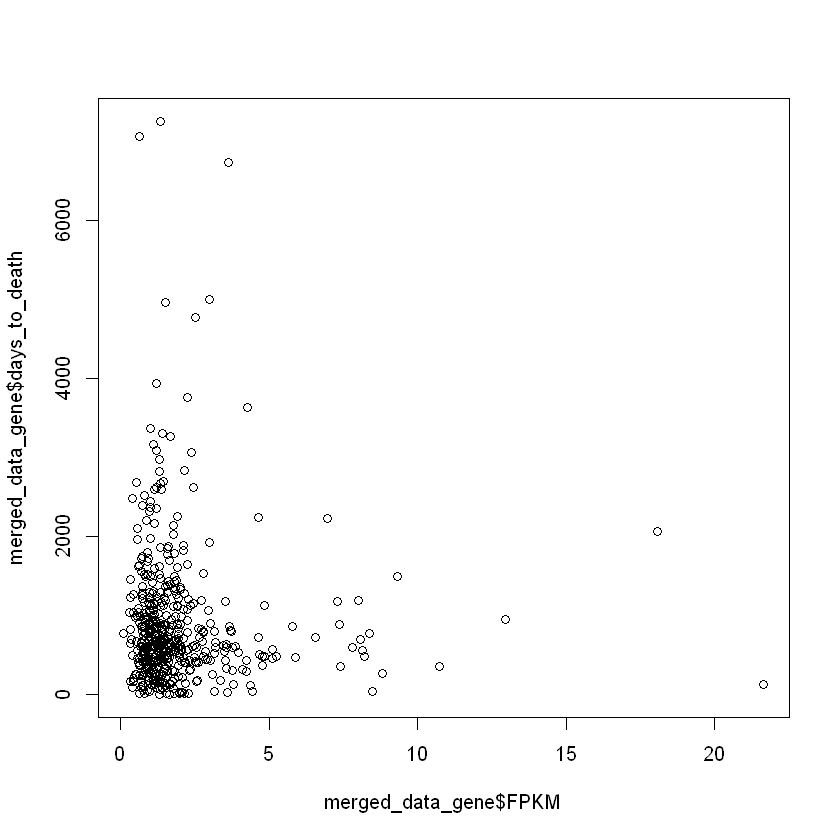

In [162]:
plot_scatter(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    "GLYCTK")

In [163]:
best_values_glyctk_all <- get_best_cutoff(
    rpkm_data, 
    clinical_data$all, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="All")

[1] "All ::: GLYCTK"
[1] "Optimized cutoff: 0.913"
[1] "Best fit p-value: 0.0772322560260469"
[1] "high: 383"
[1] "low: 104"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 487, number of events= 177 

          coef exp(coef) se(coef)    z Pr(>|z|)  
FPKMlow 0.2984    1.3478   0.1695 1.76   0.0784 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow     1.348      0.742    0.9667     1.879

Concordance= 0.524  (se = 0.019 )
Likelihood ratio test= 2.96  on 1 df,   p=0.09
Wald test            = 3.1  on 1 df,   p=0.08
Score (logrank) test = 3.12  on 1 df,   p=0.08



In [191]:
pdf("stat_dist_glyctk_all.pdf")
plot(
    best_values_glyctk_all$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [194]:
model <- best_values_glyctk_all$model
p_val <- best_values_glyctk_all$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_all.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Early stages

[1] "GLYCTK"


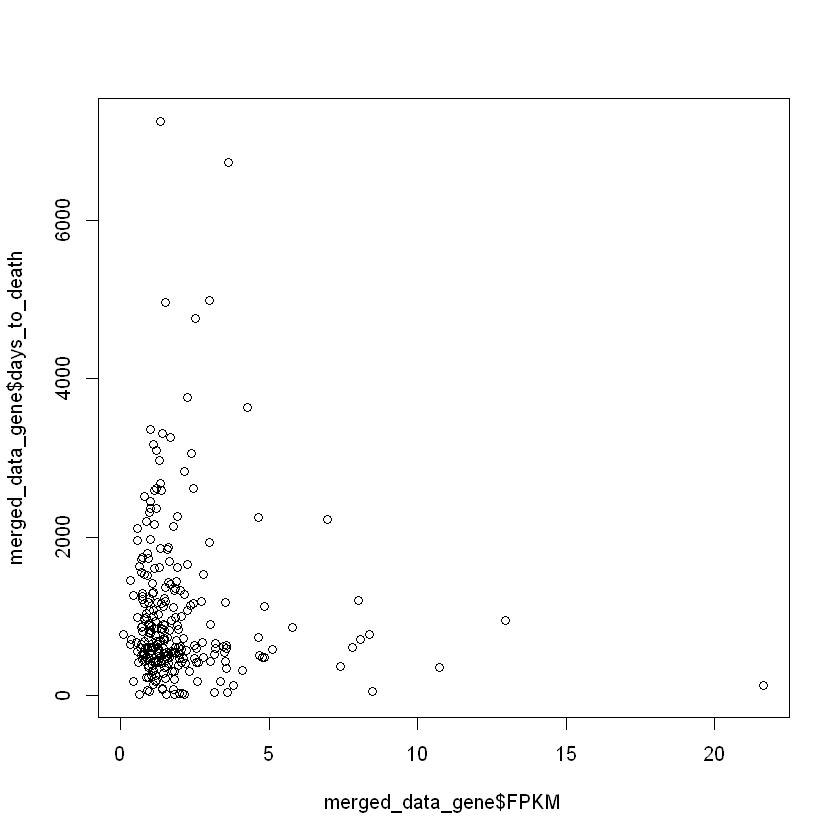

In [166]:
plot_scatter(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    "GLYCTK")

In [167]:
use_values_early <- use_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Early")

[1] "Early ::: GLYCTK"


Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
"There are no survival curves to be compared. 
 This is a null model."


[1] "Used cutoff: 0.913"
[1] "Used p-value: NA"
[1] "high: 264"
[1] "low: 0"


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [168]:
best_values_glyctk_early <- get_best_cutoff(
    rpkm_data, 
    clinical_data$early, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="early")

[1] "early ::: GLYCTK"
[1] "Optimized cutoff: 0.9349"
[1] "Best fit p-value: 0.0257739806350333"
[1] "high: 212"
[1] "low: 52"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 264, number of events= 63 

          coef exp(coef) se(coef)     z Pr(>|z|)  
FPKMlow 0.6140    1.8478   0.2798 2.195   0.0282 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow     1.848     0.5412     1.068     3.197

Concordance= 0.526  (se = 0.029 )
Likelihood ratio test= 4.44  on 1 df,   p=0.04
Wald test            = 4.82  on 1 df,   p=0.03
Score (logrank) test = 4.97  on 1 df,   p=0.03



In [192]:
pdf("stat_dist_glyctk_early.pdf")
plot(
    best_values_glyctk_early$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


png 
  2

In [195]:
model <- best_values_glyctk_early$model
p_val <- best_values_glyctk_early$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_early.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

#### Late stages

[1] "GLYCTK"


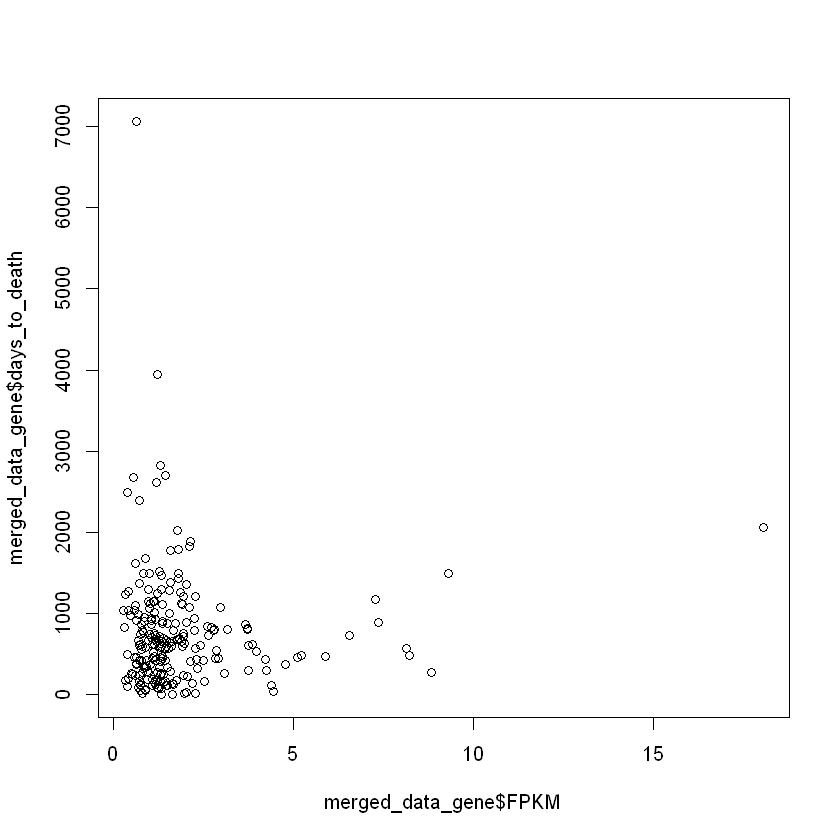

In [171]:
plot_scatter(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    "GLYCTK")

In [172]:
use_values_late <- use_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000102172", 
    best_values_glyctk_all$cutoff, 
    title="GLYCTK", 
    stage="Late")

[1] "Late ::: GLYCTK"


Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
"There are no survival curves to be compared. 
 This is a null model."


[1] "Used cutoff: 0.913"
[1] "Used p-value: NA"
[1] "high: 223"
[1] "low: 0"


ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [173]:
best_values_glyctk_late <- get_best_cutoff(
    rpkm_data, 
    clinical_data$late, 
    "ENSG00000168237", 
    title="GLYCTK", 
    stage="late")

[1] "late ::: GLYCTK"
[1] "Optimized cutoff: 1.7735"
[1] "Best fit p-value: 0.319220866718962"
[1] "high: 70"
[1] "low: 153"
Call:
coxph(formula = Surv(days_to_death, status) ~ FPKM, data = opt_categories)

  n= 223, number of events= 114 

          coef exp(coef) se(coef)     z Pr(>|z|)
FPKMlow 0.2081    1.2313   0.2097 0.992    0.321

        exp(coef) exp(-coef) lower .95 upper .95
FPKMlow     1.231     0.8121    0.8163     1.857

Concordance= 0.54  (se = 0.024 )
Likelihood ratio test= 1.01  on 1 df,   p=0.3
Wald test            = 0.98  on 1 df,   p=0.3
Score (logrank) test = 0.99  on 1 df,   p=0.3



In [193]:
pdf("stat_dist_glyctk_late.pdf")
plot(
    best_values_glyctk_late$cutoff_obj, 
    "FPKM", 
    palette = "npg", 
    bins = 50)$FPKM
dev.off()

png 
  2

In [196]:
model <- best_values_glyctk_late$model
p_val <- best_values_glyctk_late$p_val
dig_round=7
p_pos=c(6000,1)

pdf("km_opt_glyctk_late.pdf")
ggsurvplot(
    model,
    pval=round(p_val, digits = dig_round),
    risk.table = TRUE,
    conf.int=TRUE,
    conf.int.style="ribbon",
    conf.int.alpha=0.2,
    pval.method=TRUE,
    pval.size=7,
    pval.coord=p_pos,
    surv.median.line="hv",
    xscale="d_y",
    xlab="time (years)",
    palette=c("dodgerblue2", "orchid2"),
    risk.table.height=.25)
dev.off()

png 
  2

### =========================================================================================

<a id="all"><h3>Perform analysis on all genes</h3></a> 

#### All stages

In [17]:
all_genes_all <- analyze_all_genes(
    rpkm_data, 
    clinical_data$all, 
    gene_list)

[1] "Skipped 0 genes"


#### Early stages

In [18]:
all_genes_early <- analyze_all_genes(
    rpkm_data, 
    clinical_data$early, 
    gene_list)

[1] "Skipped 0 genes"


#### Late stages

In [19]:
all_genes_late <- analyze_all_genes(
    rpkm_data, 
    clinical_data$late, 
    gene_list)

[1] "Skipped 0 genes"


<a id="rank"><h3>Rank order survival p-values</h3></a>

In [20]:
# Get ranked percentile
median_pvals_sorted <- all_genes_all$median[order(unlist(all_genes_all$median), decreasing=FALSE)]
median_pvals_early_sorted <- all_genes_early$median[order(unlist(all_genes_early$median), decreasing=FALSE)]
median_pvals_late_sorted <- all_genes_late$median[order(unlist(all_genes_late$median), decreasing=FALSE)]

optimized_pvals_sorted <- all_genes_all$optimized[order(unlist(all_genes_all$optimized), decreasing=FALSE)]
optimized_pvals_early_sorted <- all_genes_early$optimized[order(unlist(all_genes_early$optimized), decreasing=FALSE)]
optimized_pvals_late_sorted <- all_genes_late$optimized[order(unlist(all_genes_late$optimized), decreasing=FALSE)]

#### SMS

In [ ]:
# Optimized

In [50]:
print(paste((which(names(optimized_pvals_sorted) == "ENSG00000102172") / length(optimized_pvals_sorted) * 100), "%"))

[1] "0.649457867796797 %"


In [179]:
print((which(names(optimized_pvals_sorted) == "ENSG00000102172")))

[1] 118


In [180]:
print(length(optimized_pvals_sorted))

[1] 18169


In [51]:
print(paste((which(names(optimized_pvals_early_sorted) == "ENSG00000102172") / length(optimized_pvals_early_sorted) * 100), "%"))

[1] "0.384869144490873 %"


In [52]:
print(paste((which(names(optimized_pvals_late_sorted) == "ENSG00000102172") / length(optimized_pvals_late_sorted) * 100), "%"))

[1] "9.99393972783869 %"


In [ ]:
# Median

In [107]:
print(paste((which(names(median_pvals_sorted) == "ENSG00000102172") / length(median_pvals_sorted) * 100), "%"))

[1] "6.96240849799108 %"


In [108]:
print(paste((which(names(median_pvals_early_sorted) == "ENSG00000102172") / length(median_pvals_early_sorted) * 100), "%"))

[1] "44.4358917967891 %"


In [109]:
print(paste((which(names(median_pvals_late_sorted) == "ENSG00000102172") / length(median_pvals_late_sorted) * 100), "%"))

[1] "21.9326758856261 %"


#### GLYCTK

In [ ]:
# Optimized

In [53]:
print(paste((which(names(optimized_pvals_sorted) == "ENSG00000168237") / length(optimized_pvals_sorted) * 100), "%"))

[1] "62.7607463261599 %"


In [54]:
print(paste((which(names(optimized_pvals_early_sorted) == "ENSG00000168237") / length(optimized_pvals_early_sorted) * 100), "%"))

[1] "16.3954255553112 %"


In [55]:
print(paste((which(names(optimized_pvals_late_sorted) == "ENSG00000168237") / length(optimized_pvals_late_sorted) * 100), "%"))

[1] "94.1601013718252 %"


In [ ]:
# Median

In [110]:
print(paste((which(names(median_pvals_sorted) == "ENSG00000168237") / length(median_pvals_sorted) * 100), "%"))

[1] "50.3494963949585 %"


In [111]:
print(paste((which(names(median_pvals_early_sorted) == "ENSG00000168237") / length(median_pvals_early_sorted) * 100), "%"))

[1] "47.3114141191995 %"


In [112]:
print(paste((which(names(median_pvals_late_sorted) == "ENSG00000168237") / length(median_pvals_late_sorted) * 100), "%"))

[1] "94.0554239435844 %"


<a id="plots"><h3>Plots</h3></a>

In [177]:
bump <- 1e-5

#### All stages

In [ ]:
# Optimized

In [200]:
# Plot distribution
optimized_pvals_bh <- p.adjust(
  optimized_pvals_sorted, 
  method = "BH", 
  n = length(optimized_pvals_sorted))

pdf('bh_dist_all.pdf', width=10, height=5)
hist(
  -1 * log10(as.numeric(optimized_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

In [ ]:
# Median

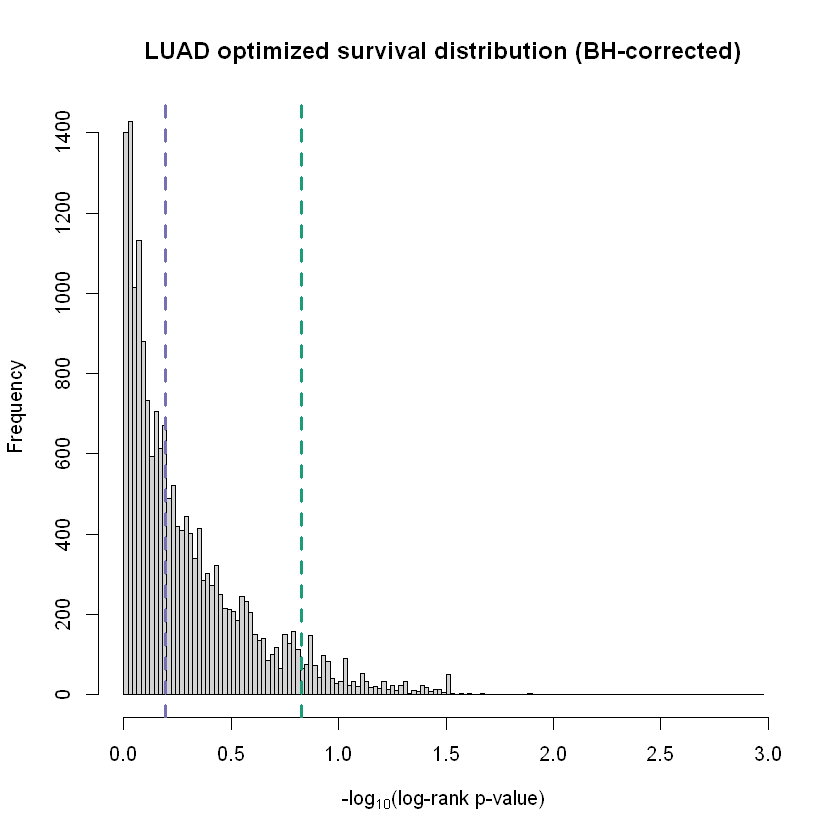

In [97]:
# Plot distribution
median_pvals_bh <- p.adjust(
  median_pvals_sorted, 
  method = "BH", 
  n = length(median_pvals_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Early stages

In [ ]:
# Optimized

In [203]:
# Plot distribution
optimized_pvals_bh_early <- p.adjust(
  optimized_pvals_early_sorted, 
  method = "BH", 
  n = length(optimized_pvals_early_sorted))

pdf('bh_dist_early.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

In [ ]:
# Median

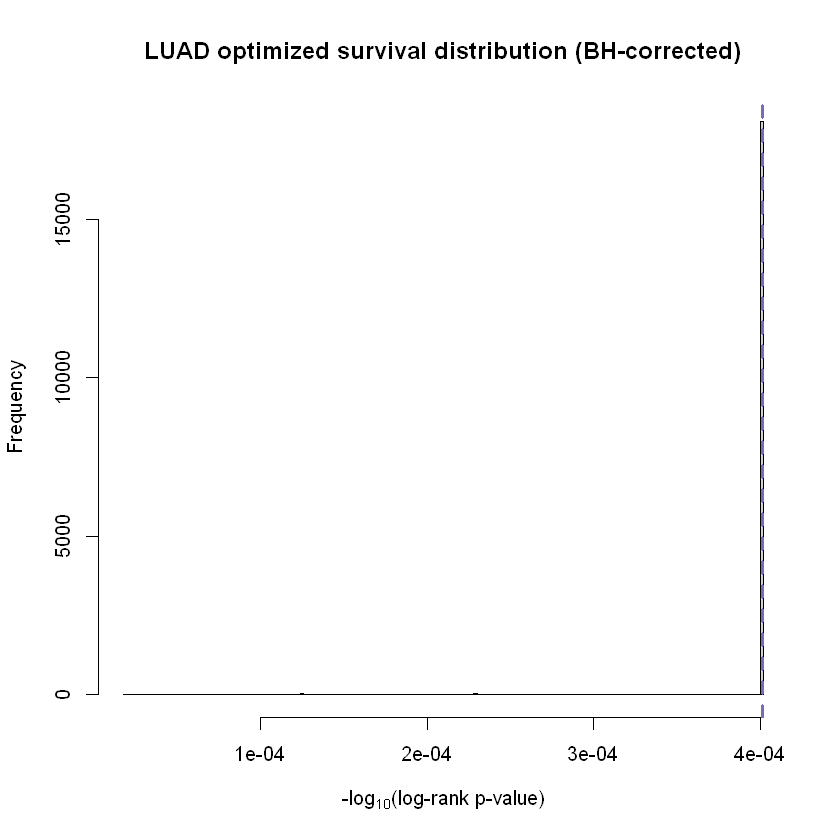

In [106]:
# Plot distribution
median_pvals_bh_early <- p.adjust(
  median_pvals_early_sorted, 
  method = "BH", 
  n = length(median_pvals_early_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh_early) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh_early['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh_early['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

#### Late Stages

In [ ]:
# Optimized

In [204]:
# Plot distribution
optimized_pvals_bh_late <- p.adjust(
  optimized_pvals_late_sorted, 
  method = "BH", 
  n = length(optimized_pvals_late_sorted))

pdf('bh_dist_late.pdf')
hist(
  -1 * log10(as.numeric(optimized_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(optimized_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)
dev.off()

png 
  2

In [ ]:
# Median

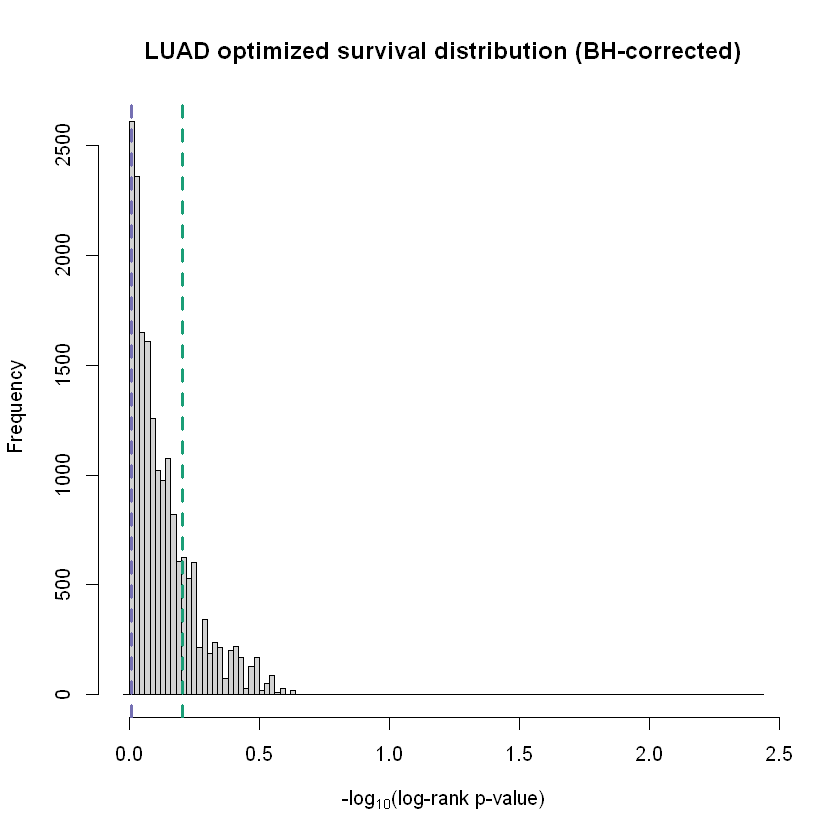

In [99]:
# Plot distribution
median_pvals_bh_late <- p.adjust(
  median_pvals_late_sorted, 
  method = "BH", 
  n = length(median_pvals_late_sorted))

#pdf('bh_dist_all.pdf')
hist(
  -1 * log10(as.numeric(median_pvals_bh_late) + bump),
  breaks=150,
  main="LUAD optimized survival distribution (BH-corrected)",
  xlab=expression("-log"[10]*"(log-rank p-value)"))
abline(v = -1 * log10(median_pvals_bh_late['ENSG00000102172'] + bump), col="#1b9e77", lwd=3, lty=2)
abline(v = -1 * log10(median_pvals_bh_late['ENSG00000168237'] + bump), col="#7570b3", lwd=3, lty=2)

<a id="session"><h3>Session Info</h3></a>

In [178]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] data.table_1.13.6 stringr_1.4.0     survminer_0.4.9   ggpubr_0.4.0     
[5] ggplot2_3.3.3     survival_3.2-11  

loaded via a namespace (and not attached):
 [1] tidyr_1.1.2           jsonlite_1.7.2        splines_4.0.2        
 [4] maxstat_0.7-25        carData_3.0-4         assertthat_0.2.1     
 [7] cellranger_1.1.0      pillar_1.6.0          backports_1.2.1      
[10] lattice_0.20-41       glue_1.4.2            uuid_0.1-4           
[13] digest_0.6.27         ggsignif_0.6.1        gridtext_0.1.4   